<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar5/Trees_Bagging_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar: Trees, Bootstrap Aggregation (Bagging) and Random Forest
Machine Learning by professor Evgeny Burnaev
<br\>
Author: Andrey Lange

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 5)

# Example 1: Regression tree

          x1         y
0   1.646441  0.192209
1   2.145568 -0.743480
..       ...       ...
98  2.486820  1.053474
99  0.014086  0.104399

[100 rows x 2 columns]


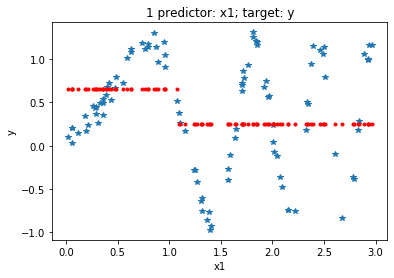

Mean Squared Error:  0.3550636421014569


In [2]:
# prepare and show a dataset
n = 1                         # number of features
N = 100**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))/3
y = y.ravel()
print((pd.DataFrame({'x1': X[:, 0], 'y': y})))
plt.plot(X, y, '*')
plt.title('1 predictor: x1; target: y')
plt.xlabel('x1')
plt.ylabel('y')

# train and predict a regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X, y)
y_pred = clf.predict(X)

plt.plot(X, y_pred, '.r')
plt.show()

print('Mean Squared Error: ', mean_squared_error(y, y_pred))

### Question 1.1: Change the number of levels in a regression tree above until the best approximation of the training set. What is the best MSE?

### Question 1.2: Calculate MSE above without `mean_squared_error()` calling.

## Example 2: Regression tree with $n=2$ features

### Question 2.1: Lets try an example with $n=2$ features. Train a regression stump (a tree of a depth 1) and see the optimal threshold (border between colors) for the best feature chosen for split among $x_1$ and $x_2$. What feature was chosen and why? Change something in the string 
```
coeffs = np.array([[0.2], [1.5]])
```
### to make another feature is chosen as the best for split.



### Question 2.2: Find the optimal `max_depth` hyperparameter when MSE on the training set is the best.

            x1        x2         y
0     0.987864  1.287341  0.575163
1     1.084974  0.980790  1.007940
...        ...       ...       ...
9998  0.536880  0.803620  1.100161
9999  0.648228  1.126596  1.127278

[10000 rows x 3 columns]


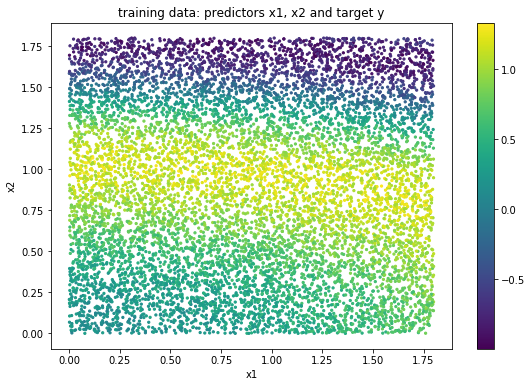

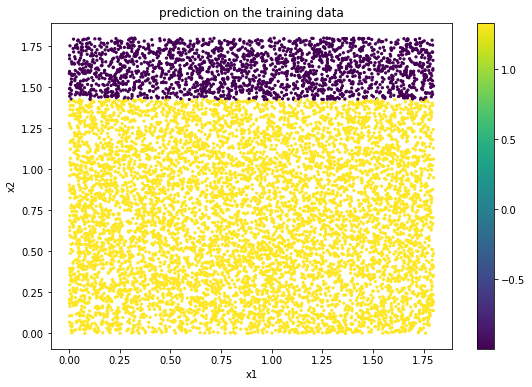

Mean Squared Error:  0.11082700085308704


In [3]:
# prepare and show a dataset in 2D
n = 2               # number of features
N = 100**n          # number of samples
np.random.seed(0)
X = np.random.random((N, n))*1.8

# Change something to make another feature is chosen for split by some optimal threshold
coeffs = np.array([[0.2], [1.5]])
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))/3

# print dataset
print((pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y.ravel()})))

# show target y in (x1, x2) space
plt.figure(figsize=[9, 6])
sc = plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=5)
plt.colorbar(sc)
plt.title('training data: predictors x1, x2 and target y')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# train and predict by a regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X, y)
y_pred = clf.predict(X)

# show prediction in (x1, x2) space
plt.figure(figsize=[9, 6])
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=5)
plt.colorbar(sc)
plt.title('prediction on the training data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print('Mean Squared Error: ', mean_squared_error(y, y_pred))

## Example 3: Regression tree: training and testing sets

### Question 3.1: Now we consider training and testing sets. Try different depths of a decision tree to see when the model is underfitted and when the one is overfitted to the training set. Plot the MSE on the testing set depending on `max_depth` hyperparameter. What is the optimal value?

train MSE:  0.30958479412099965
test MSE:  0.39250699800032424


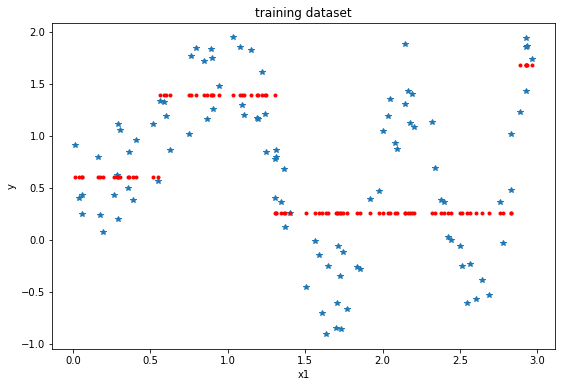

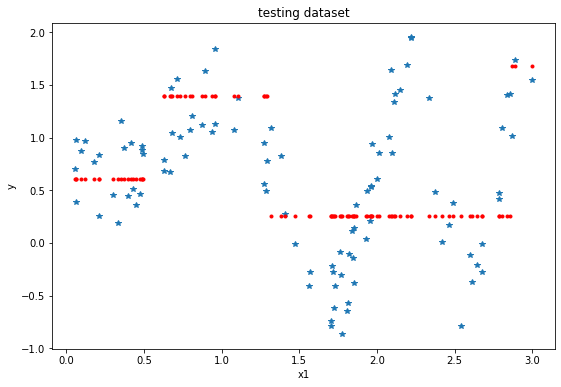

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 1                         # number of features
N = 200**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- change this block to select the best max_depth
clf = DecisionTreeRegressor(max_depth=2)
clf.fit(X_train, y_train)
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

plt.figure(figsize=[9, 6])
plt.plot(X_train, y_train, '*')
plt.plot(X_train, clf.predict(X_train), '.r')
plt.title('training dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.figure(figsize=[9, 6])
plt.plot(X_test, y_test, '*')
plt.plot(X_test, clf.predict(X_test), '.r')
plt.title('testing dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

### Question 3.2. How many constant-valued regions of red points are on the picture when `max_depth=5`?



# Example 4: Bagging = Decision Tree + Bootstrap
### In the question above we've found the optimal `max_depth` for the case of single Decision Tree. By limiting the tree depth we distort the fitting to the training dataset and prevent the model from overfitting. 
### The second way to prevent overfitting is to distort the ... training dataset itself. What is Bagging?
### We train many trees each on a Bootstraped training dataset (it contains the same number of samples but some of them are included with some number of their copies, and some of them are not included). Then we average over all such trees. It is called Bootstrap aggregation - Bagging.

### Question 4.1: Compare the prediction above (single tree) with Bagging all with `max_depth=5`. Why Bagging approximation red dots does not look like constant-valued regions as in a single decision tree? Tune the best number of trees. Has  Bagging improved the single tree model regarding `test MSE`?

### Question 4.2: Sometimes it is good to be a perfectionist and unittest any code :). Unittest scikit-learn! Should `DecisionTreeRegressor` and `BaggingRegressor`  give the same results in some special case? Simplify Bagging to the single Decision Tree and show the same pictures as above when `max_depth=5`. What parameter `n_estimators` have to be set to? Do we need to change any other hyperparameters?

train MSE:  0.022073638159329965
test MSE:  0.14843728255185615


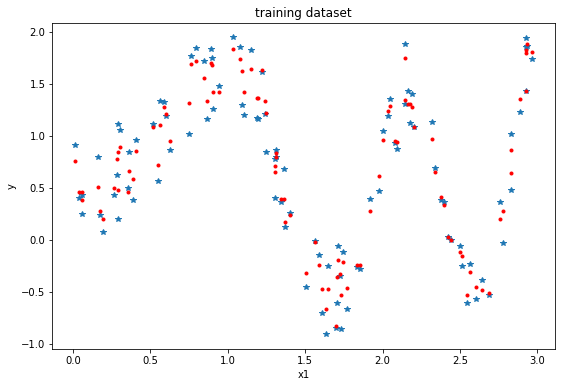

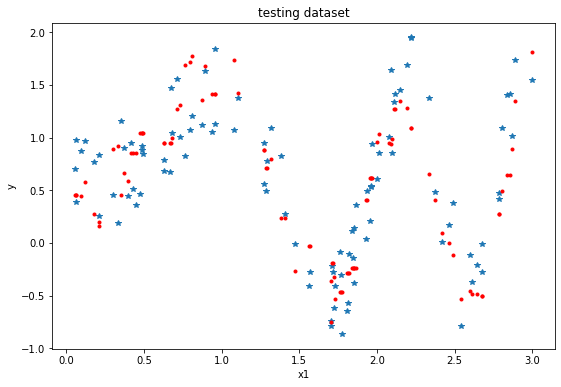

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 1                         # number of features
N = 200**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- 1. change this block to select the best n_estimators
# --- 2. change this block to simplify Bagging to ordinary single decision tree
clf = BaggingRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=10, bootstrap=True, random_state=0)
clf.fit(X_train, y_train.ravel())
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

plt.figure(figsize=[9, 6])
plt.plot(X_train, y_train, '*')
plt.plot(X_train, clf.predict(X_train), '.r')
plt.title('training dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.figure(figsize=[9, 6])
plt.plot(X_test, y_test, '*')
plt.plot(X_test, clf.predict(X_test), '.r')
plt.title('testing dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

### Question 4.3: Estimate the part of points that are not selected after Bootstrap procedure analytically. Consider the sample of a size $N\to\infty$.

# Example 5: Random Forest = Bagging + (`max_features' < $n$)

## Can we reduce the overfitting more? - YES!!! <br> Along with Bootstrap reduce the number of features among which the best feature for each tree in ensemble is chosen!

### Question 5.1: Tune `max_features` to improve the tesing MSE. Check that testing MSE becomes better. And what happens with training MSE and why?

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 100           # number of features
N = 10**4         # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- change this block to select the best max_features
clf = RandomForestRegressor(max_depth=5, n_estimators=10, max_features=n, random_state=0)
clf.fit(X_train, y_train.ravel())
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

train MSE:  0.523909750433318
test MSE:  0.5915306241928471


# Example 6: Feature Importance

In [ ]:
# Load data from Kaggle

X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar5/data/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

n_features = X_train.shape[1]
clf = GridSearchCV(RandomForestClassifier(),
                   # you can play with tuning, up to your CPU performance:
#                  {'max_depth': [1, 3, 5], 'n_estimators': [10, 50, 150], 'max_features': ['auto', n_features]},
                   {'max_depth': [5], 'n_estimators': [250], 'max_features': [n_features]}, # equivalent to Bagging when max_features = n_features
                   cv = 3)
clf.fit(X_train, y_train)
print('best accuracy score:', clf.best_score_) # validation score

# now let's draw ROC curve
plt.figure(figsize=[9, 6])
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, 'r', label='train')
plt.title('ROC curves')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# feature importances
fi = pd.Series(clf.best_estimator_.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.show()

### Be careful with `feature_importances`: If we add just copies of a feature, the importances of all copies are not the same (see `NumberOfTimes90DaysLate` and its 2 copies). Although, after adding extremly correlated features (here they are identical) the values of importance have been decreased (see the scale along vertical axis), which is expected, because similar features can share their common similar importance.



In [ ]:
X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar5/data/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

X_train['NumberOfTimes90DaysLate_2'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_3'] = X_train['NumberOfTimes90DaysLate']

n_features = X_train.shape[1]
clf = GridSearchCV(RandomForestClassifier(),
                   # you can play with tuning, up to your CPU performance:
                   {'max_depth': [5], 'n_estimators': [250], 'max_features': [n_features]},
                   cv = 3)
clf.fit(X_train, y_train)

# feature importances
fi = pd.Series(clf.best_estimator_.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.show()

### Unlike to the fact above, after excluding some highly correlated features, the importances of others remaining have not been increased. It means that although they are highly correlated and reflect similar information in the data, small differences between them are still significant.


In [ ]:
X_train[['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']].corr()

In [ ]:
X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar5/data/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

# X_train['NumberOfTimes90DaysLate_2'] = X_train['NumberOfTimes90DaysLate']
# X_train['NumberOfTimes90DaysLate_3'] = X_train['NumberOfTimes90DaysLate']
X_train = X_train.drop(['NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

n_features = X_train.shape[1]
clf = GridSearchCV(RandomForestClassifier(),
                   # you can play with tuning, up to your CPU performance:
                   {'max_depth': [5], 'n_estimators': [250], 'max_features': [n_features]},
                   cv = 3)
clf.fit(X_train, y_train)

# feature importances
fi = pd.Series(clf.best_estimator_.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.show()